In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


In [131]:
import os
import cv2
import json
import glob
import torch
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm


pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [132]:
from params import *


from data.dataset import *
from data.transforms import *
from data.preparation import *
from data.sagital_to_axial import get_axial_coords

from model_zoo.models import define_model
from util.torch import load_model_weights
from util.plots import *

from inference.lvl1 import Config

### Sagittal

In [133]:
# EXP_FOLDER = "../logs/2024-08-12/22/"  # 20 ep
# EXP_FOLDER = "../logs/2024-08-12/26/"  # 30 ep
# EXP_FOLDER = "../logs/2024-08-12/27/"  # coatnet_rmlp_2_rw_384
# EXP_FOLDER = "../logs/2024-08-12/28/"  # coatnet_1
# EXP_FOLDER = "../logs/2024-08-12/29/"  # coatnet_rmlp_2_rw_384 lr =3e-4
# EXP_FOLDER = "../logs/2024-08-12/30/"  # coatnet_rmlp_2_rw_384 30ep

EXP_FOLDER = "../logs/2024-08-12/31/"  # coatnet_rmlp_2_rw_384 20 ep
EXP_FOLDER = "../logs/2024-08-12/32/"  # coatnet_rmlp_2_rw_384 30 ep

FOLD = 0

In [134]:
df = prepare_coords_data()

In [135]:
config = Config(json.load(open(EXP_FOLDER + "config.json", "r")))

folds = pd.read_csv(config.folds_file)
df = df.merge(folds, how="left")
df['fold'] = df['fold'].fillna(-1)

In [136]:
PLOT = True

In [137]:
df_sev = prepare_data_crop(DATA_PATH)

  0%|          | 0/989 [00:00<?, ?it/s]

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]]


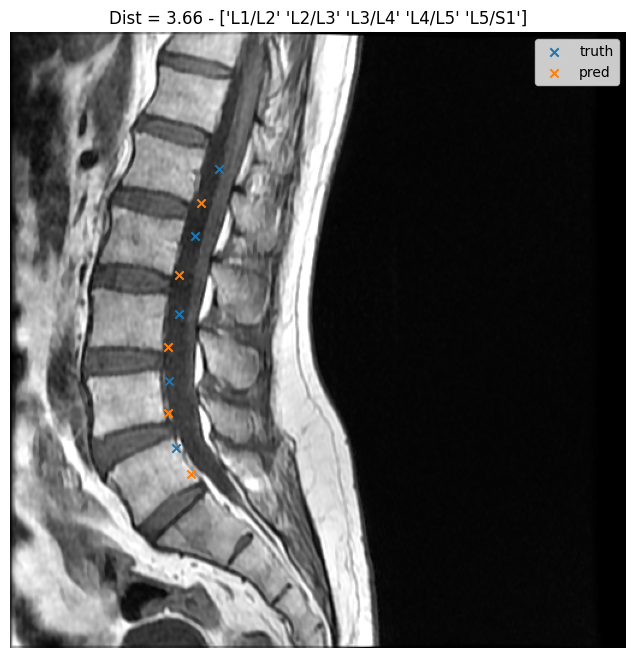

SCS / L-NFN / R-NFN / L-SS / R-SS
[[ 0  0  0 -1 -1]
 [ 0  0  0 -1 -1]
 [ 0  0  0  0  1]
 [ 0  2  1  0  1]
 [ 0  0  0  0  0]]


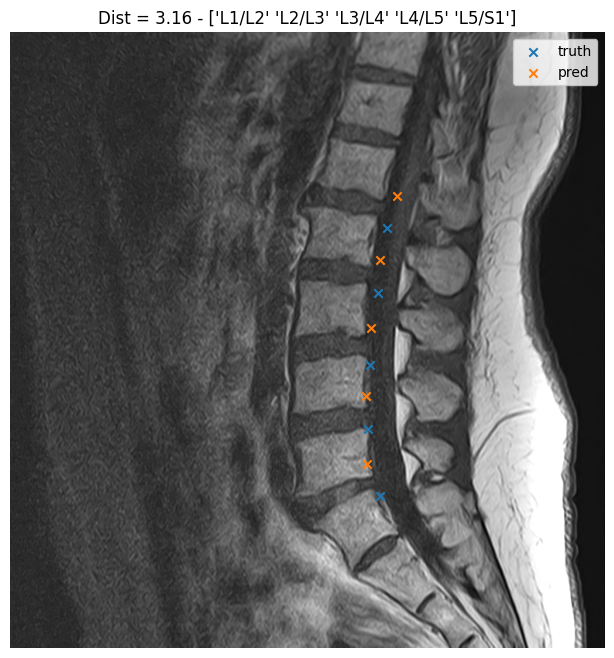

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 0 0]
 [2 1 1 1 1]
 [0 1 1 1 0]]


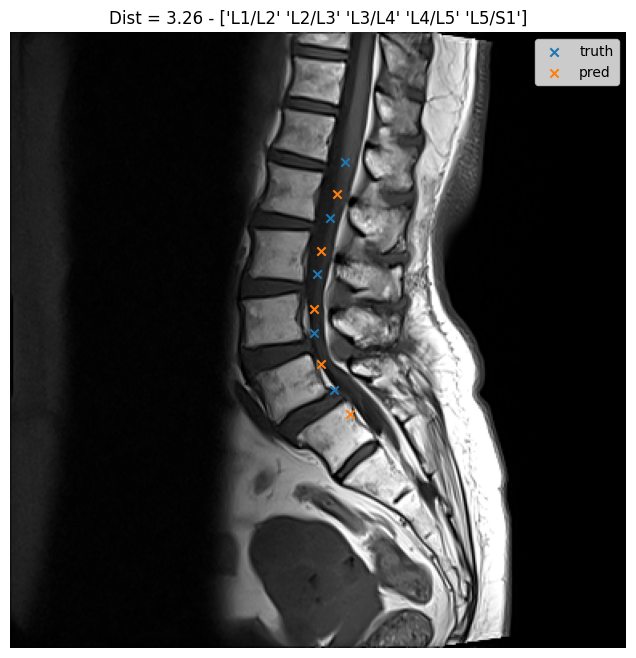

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


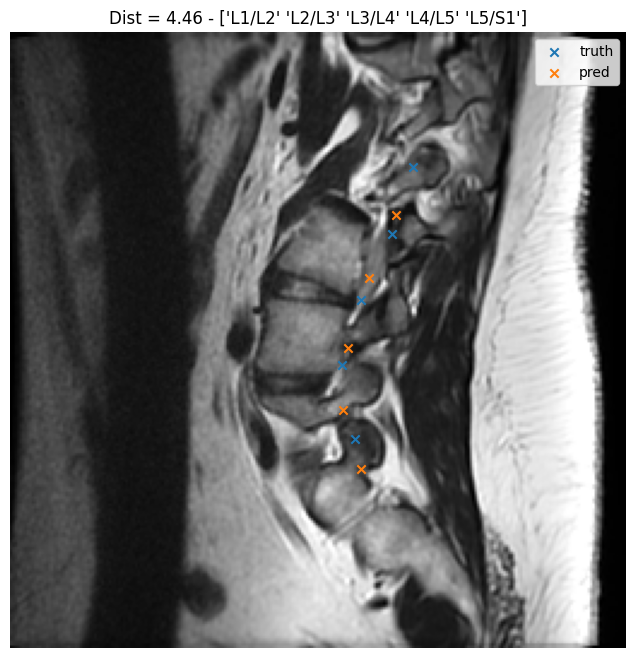

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


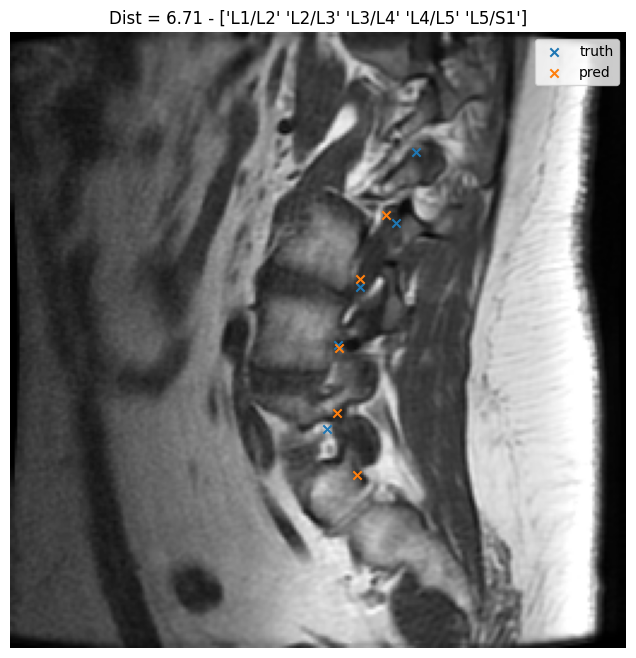

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 1 1 1 1]]


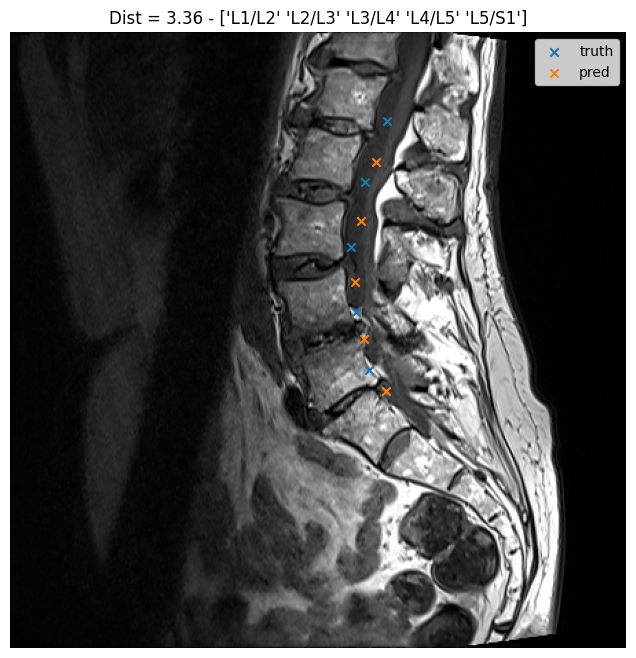

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 2 0 1]
 [0 0 0 0 2]]


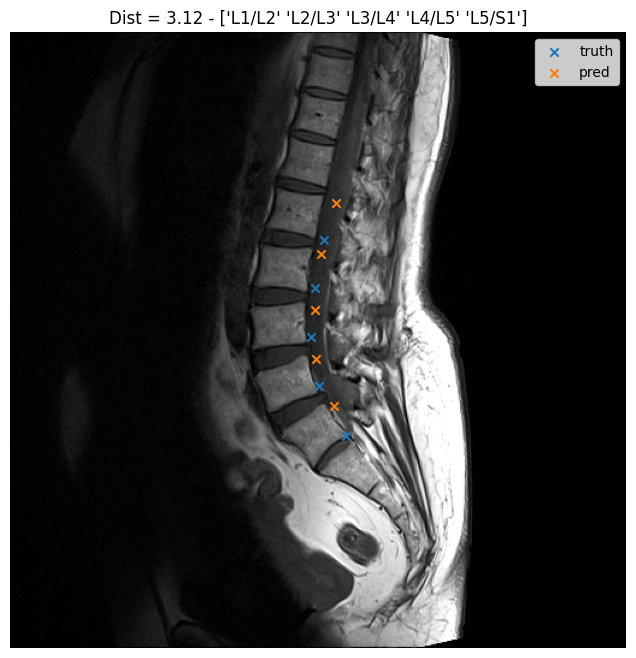

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [1 0 1 1 0]
 [0 0 1 1 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


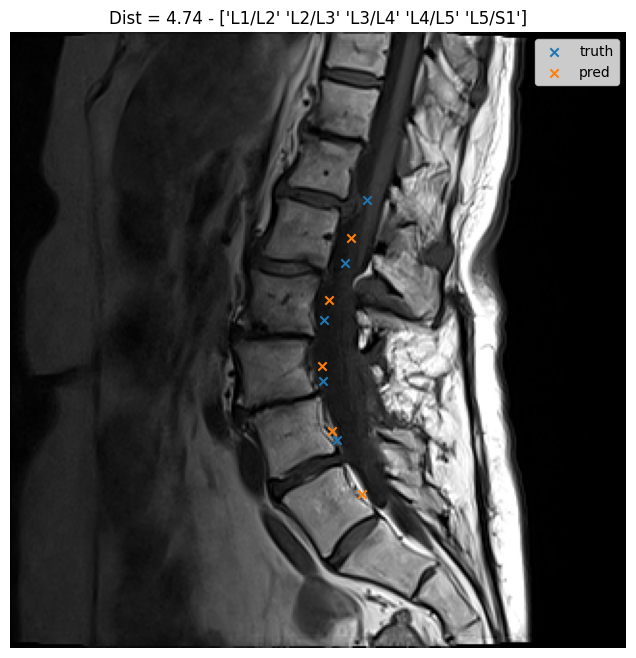

SCS / L-NFN / R-NFN / L-SS / R-SS
[[ 0  0 -1  0  0]
 [ 0  1 -1  2  1]
 [ 0  2 -1  2  0]
 [ 0  1 -1  2  2]
 [ 0  0 -1  1  2]]


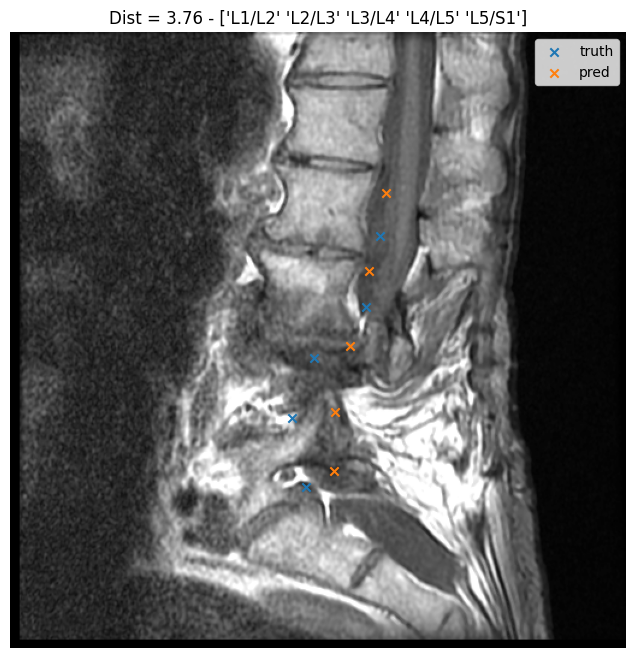

SCS / L-NFN / R-NFN / L-SS / R-SS
[[ 0  0 -1  0  0]
 [ 0  1 -1  2  1]
 [ 0  2 -1  2  0]
 [ 0  1 -1  2  2]
 [ 0  0 -1  1  2]]


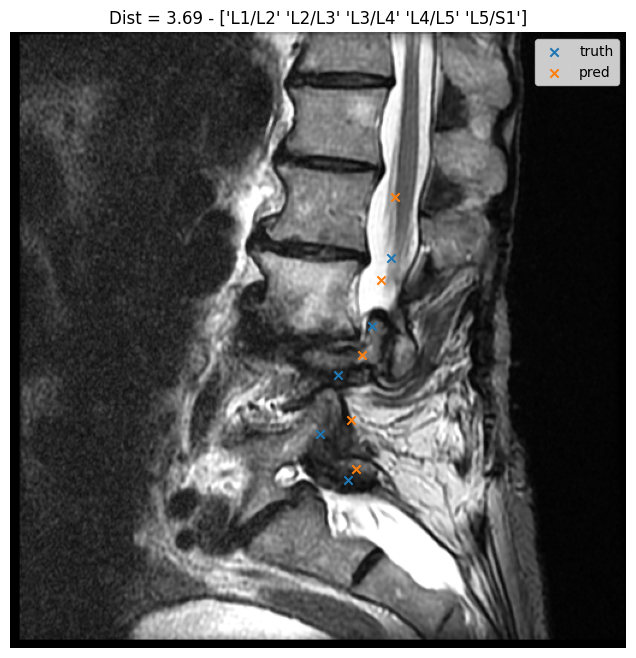

SCS / L-NFN / R-NFN / L-SS / R-SS
[[ 0  0  0 -1 -1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  1  0  0]
 [ 0  1  0  1  2]]


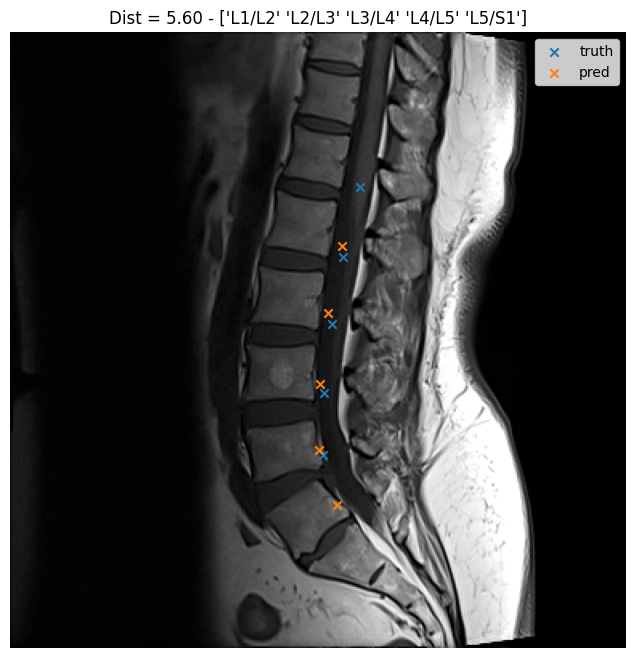

SCS / L-NFN / R-NFN / L-SS / R-SS
[[ 0  0  0 -1 -1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  1  1  0  0]
 [ 0  1  0  1  2]]


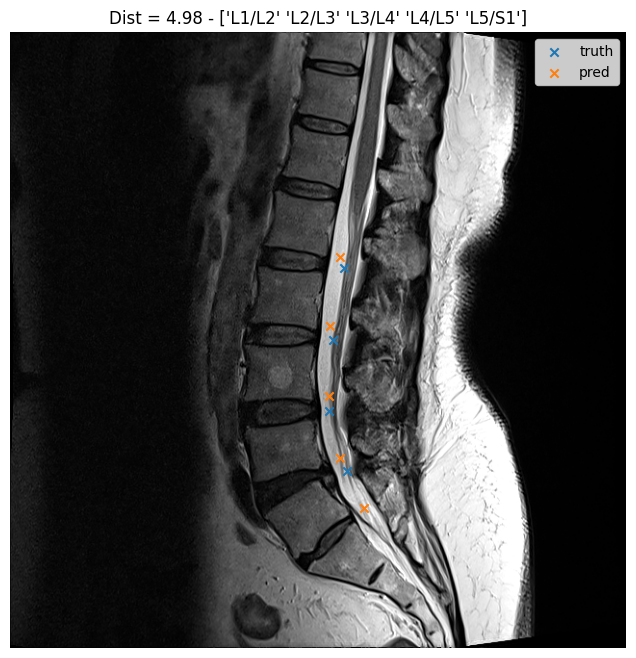

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]


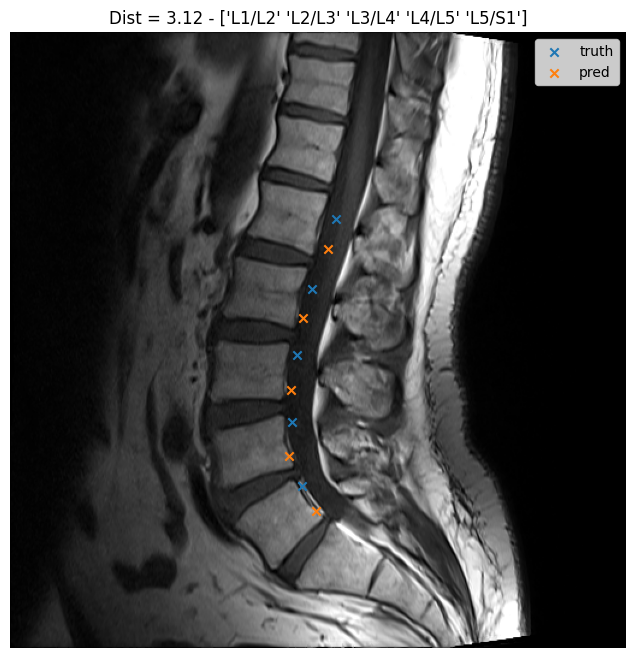

SCS / L-NFN / R-NFN / L-SS / R-SS
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


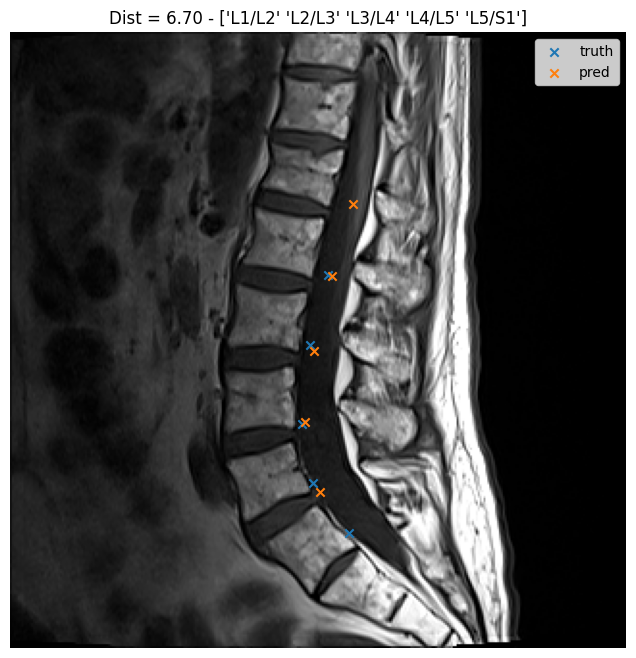

In [126]:
ds = []
df_ = prepare_data()

for fold in range(4):
    preds = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df['fold'] == fold].reset_index(drop=True)
    dataset = CoordsDataset(df_val, transforms=None)

    for idx in tqdm(range(len(dataset))):
        img, y, _ = dataset[idx]

        study = df_val['study_id'][idx]
        labels = np.vstack(df_sev[df_sev['study_id'] == study]['target'].values[:5])
        # print(labels)

        # l = np.array(LEVELS)[np.where(y.numpy().sum(-1) > 0)[0]]
        
        p = preds[idx].reshape(-1, 2)
        d = np.abs(p - y.numpy()) * 100
        d = d[y.sum(-1) > 0].mean()
        ds.append(d)

        # if d < 4:
        #     continue
        # print(df_val["series_id"][idx])

        if PLOT:
            if d > 3:
                y = y[y.sum(-1) > 0]

                print('SCS / L-NFN / R-NFN / L-SS / R-SS')
                print(labels)

                plt.figure(figsize=(8, 8))
                plt.imshow(img)
                plt.scatter(y[:, 0] * img.shape[1], y[:, 1] * img.shape[0], marker="x", label="truth")
                plt.scatter(p[:, 0] * img.shape[1], p[:, 1] * img.shape[0], marker="x", label="pred")
                plt.title(f'Dist = {d:.2f} - {l}')
                plt.axis(False)
                plt.legend()
                plt.show()

            # if idx > 100:
                # break
    # if PLOT:
    break


### Eval

In [115]:
print('Images with error > 5%:', (np.array(ds) > 5).sum())
print('Images with error > 4%:', (np.array(ds) > 4).sum())
print('Images with error > 3%:', (np.array(ds) > 3).sum())

Images with error > 5%: 3
Images with error > 4%: 6
Images with error > 3%: 14


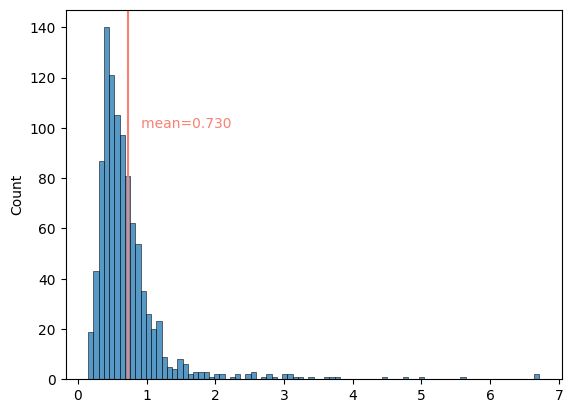

In [116]:
sns.histplot(ds)
plt.axvline(np.mean(ds), c="salmon")
plt.text(np.mean(ds), 100, f"   mean={np.mean(ds):.3f}", color="salmon")
plt.show()

## Axial

In [90]:
ref_studies = [
    # 113758629,
    # 13317052, 60612428, 74294498, 142991438, 
    # 168833126, 189360935, 58813022, 1115952008, 959290081,
    2388577668  # bugged
]

PLOT = False
SAVE = True

SIZE = 0.15
SAVE_FOLDER = f"../input/crops_ax_{SIZE}/"

os.makedirs(SAVE_FOLDER, exist_ok=True)

In [91]:
EXP_FOLDER_AX = "../logs/2024-08-26/3/"

config = Config(json.load(open(EXP_FOLDER_AX + "config.json", "r")))

models_ax = []
for fold in range(4):
    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        pooling=config.pooling,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        pretrained=False,
    )
    model = model.cuda().eval()

    weights = EXP_FOLDER_AX + f"{config.name}_{fold}.pt"
    model = load_model_weights(model, weights, verbose=config.local_rank == 0)
    models_ax.append(model)

    # break


 -> Loading encoder weights from ../logs/2024-08-26/3/coatnet_1_rw_224_0.pt


 -> Loading encoder weights from ../logs/2024-08-26/3/coatnet_1_rw_224_1.pt


 -> Loading encoder weights from ../logs/2024-08-26/3/coatnet_1_rw_224_2.pt


 -> Loading encoder weights from ../logs/2024-08-26/3/coatnet_1_rw_224_3.pt



In [92]:
df = prepare_coords_data()

folds = pd.read_csv(config.folds_file)
df = df.merge(folds, how="left")
df['fold'] = df['fold'].fillna(-1)

In [93]:
df_ = prepare_data()
df_coords = pd.read_csv(DATA_PATH + "train_label_coordinates.csv")

In [97]:
coords = []
axial_coords = []

for fold in range(4):
    preds_coords = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df["fold"] == fold].reset_index(drop=True)

    for idx in tqdm(range(len(df_val))):
        study = df_val["study_id"][idx]
        series = df_val["series_id"][idx]

        # if not study in ref_studies:
        #     continue

        # Get axial projection
        p = preds_coords[idx].reshape(-1, 2)

        img = cv2.imread(df_val["img_path"][idx])
        h, w, _ = img.shape

        world_point, assigned_level, closest_z, df_axial = get_axial_coords(
            study,
            series,
            p.copy(),
            h,
            w,
            df_,
            "../input/train_images/",
        )

        if closest_z.max() == 0:  # Fix
            world_point[:, -1] -= (world_point[:, -1].mean() - df_axial.projection.mean())
            world_point, assigned_level, closest_z, df_axial = get_axial_coords(
                study,
                series,
                p.copy(),
                h,
                w,
                df_,
                "../input/train_images/",
                world_point=world_point
            )

        # Evaluate
        series_ax = df_axial["series_id"].values[0]
        df_gt = df_coords[df_coords["series_id"] == series_ax].reset_index(drop=True)
        df_gt = df_gt[["instance_number", "level", "x", "y"]].groupby("level").mean().sort_index()
        gt = df_gt["instance_number"].values.flatten()
        preds = df_axial["instance_number"].values[closest_z]

        if len(df_gt) == 5:
            mae = np.abs(gt - preds).mean()
            # df_gt["pred"] = preds
        else:
            mae = 0

        # Locate disk
        imgs = np.load(f'../input/npy2/{study}_{series_ax}.npy')

        with torch.no_grad():
            x = torch.tensor(imgs[closest_z].astype(np.float32)).cuda()

            min_ = x.amin((-1, -2), keepdim=True)
            max_ = x.amax((-1, -2), keepdim=True)
            x = (x - min_) / (max_ - min_)
            x =  F.interpolate(
                x.unsqueeze(1).repeat(1, 3, 1, 1),
                config.resize,
                mode="bilinear",
            )

            preds_ax = models_ax[fold](x)[0].sigmoid().detach().cpu().numpy().reshape(x.size(0), 2, 2)

        preds_ax[:, :, 0] *= imgs.shape[2]
        preds_ax[:, :, 1] *= imgs.shape[1]
        
        # Crop
        crop_imgs = []
        for i in range(5):
            f = closest_z[i]
            fs = max(closest_z[i] - 3, 0)
            fe = min(closest_z[i] + 3, len(imgs))

            xc, yc = preds_ax[i].mean(0).astype(int)
            dx, dy = int(imgs.shape[2] * SIZE), int(imgs.shape[1] * SIZE)
            x0, x1 = max(xc - dx, 0), min(xc + dx, imgs.shape[2])
            y0, y1 = max(yc - dy, 0), min(yc + dy, imgs.shape[1])

            d = SIZE // 2
            crop = imgs[fs: fe, y0: y1, x0: x1]
            crop_imgs.append(crop[len(crop) // 2])

            if SAVE:
                np.save(SAVE_FOLDER + f"{study}_{series_ax}_{LEVELS_[i]}.npy", crop.copy())

        # Plot
        if PLOT:
            plt.figure(figsize=(25, 5))
            for i in range(5):
                plt.subplot(1, 5, i + 1)
                plt.imshow(crop_imgs[i], cmap="gray")
            plt.show()
            
            # display(df_gt)
            # plot_coords(
            #     world_point,
            #     assigned_level,
            #     closest_z,
            #     h,
            #     w,
            #     df_axial,
            #     title=f"Study {study} - Series {series_ax}",
            # )

            df_lvl = df_coords[df_coords["series_id"] == series_ax].reset_index(drop=True)
            plt.figure(figsize=(25, 5))
            for i in range(5):
                plt.subplot(1, 5, i + 1)

                img = imgs[closest_z[i]]

                df_lvl_ = df_lvl[df_lvl["level"] == LEVELS[i]]
                x, y = df_lvl_['x'].values, df_lvl_["y"].values

                plt.scatter(preds_ax[i, :, 0], preds_ax[i, :, 1], label="pred")
                plt.scatter(x, y, label="truth", marker="x")

                plt.imshow(img, cmap="gray")
                plt.legend()
                plt.axis(False)
                plt.title(str(df_axial["instance_number"][closest_z[i]]))

            plt.show()
            if idx > 5:
                break
    if PLOT:
        break

  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/989 [00:00<?, ?it/s]

  0%|          | 0/988 [00:00<?, ?it/s]

  0%|          | 0/986 [00:00<?, ?it/s]

## Crop Sagittal

In [ ]:
DELTA = 0.15

SAVE = True
PLOT = False

SAVE_FOLDER = f"../input/coords_crops_{DELTA}/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [ ]:
ds = []

for fold in range(4):
    pred_val = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df['fold'] == fold].reset_index(drop=True)

    for idx in tqdm(range(len(df_val))):
        study_series = df_val["img_path"][idx].split('/')[-1][:-4]
        imgs_path = DATA_PATH + "npy/" + study_series + ".npy"
        imgs = np.load(imgs_path)

        preds = pred_val[idx].reshape(-1, 2)

        crops = np.concatenate([preds, preds], -1)
        crops[:, [0, 1]] -= DELTA
        crops[:, [2, 3]] += DELTA
        crops[:, [0, 2]] *= imgs.shape[2]
        crops[:, [1, 3]] *= imgs.shape[1]
        crops = crops.astype(int)

        preds[:, 0] *= imgs.shape[2]
        preds[:, 1] *= imgs.shape[1]

        # print(df_val["series_id"][idx])

        if SAVE:
            for i, (x0, y0, x1, y1) in enumerate(crops):
                crop = imgs[:, y0: y1, x0: x1].copy()
                np.save(SAVE_FOLDER + f'{study_series}_{LEVELS_[i]}.npy', crop)

                # cc = np.load(SAVE_FOLDER + study_series + "_" + LEVELS_[i] + ".npy")
                # plt.imshow(cc[len(cc) // 2], cmap="gray")
                # plt.show()

        if PLOT:
            plt.figure(figsize=(8, 8))
            plt.imshow(imgs[len(imgs) // 2], cmap="gray")
            plt.scatter(preds[:, 0], preds[:, 1], marker="x", label="pred")
            plt.scatter(crops[:, 0], crops[:, 1], marker="x", label="pred")
            plt.scatter(crops[:, 2], crops[:, 3], marker="x", label="pred")
            plt.title(study_series)
            plt.axis(False)
            plt.legend()
            plt.show()
            break

Done ! 